# Text Summarization Fine Tuning

## Resources
- Verify the availability of notebook resources
- Fine-tuning necessitates the use of either a GPU or a TPU

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 12 14:18:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install Libraries
+ hugging face
+ PyTorch
+ Standard Python data science libraries

In [ ]:
%pip install transformers datasets evaluate accelerate pipeline bitsandbytes
%pip install torch torchdata
%pip install peft
%pip install loralib
%pip install bert_score
%pip install rouge_score
%pip install huggingface_hub

In [5]:
import pandas as pd
import numpy as np
import json
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    GenerationConfig,
    TrainingArguments,
    Trainer,
    pipeline,
    BitsAndBytesConfig,
    DataCollatorForSeq2Seq
)
import torch
import evaluate
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
    PeftConfig,
)
from huggingface_hub import login

### HuggingFace Authentication
+ Authenticate to pull models and datasets (read token required)
+ Authenticate to push models to hugging face hub (write token required)


In [ ]:
login()

### Notebook Config
+ Define some useful constants
+ Device (CPU or CUDA for distributed environments)
+ Model Paths (saving model checkpoints)
+ Setting a template for seaborn plotting

In [7]:
# training directory
MNAME = 'summarize'
DIR_TRAIN = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/{MNAME}/peft/train/"
DIR_MODEL = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/{MNAME}/peft/models/"
DIR_EVAL = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/{MNAME}/"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [8]:
# Color Palettes
colors = {
    "sage"     : "#53808D",
    "orange"   : "#FC4C02",
    "blue"     : "#1B99D6",
    "yellow"   : "#FFF57B",
    "darkgrey" : "#585858",
    "lightgrey": "#D5DADD",
    "lightsage": '#E9F2EF'
}
palette_discete = sns.color_palette([v for k,v in colors.items()])
palette_continuous = sns.color_palette(f"blend:{colors['sage']},{colors['orange']}", as_cmap=True)

# custom theme
rc = {
    'axes.facecolor':f"{colors['lightsage']}",
    "axes.edgecolor":f"{colors['sage']}",
    "text.color":f"{colors['sage']}",
    "axes.labelcolor":f"{colors['sage']}",
    "ytick.color":f"{colors['sage']}",
    "xtick.color":f"{colors['sage']}",
}
sns.set_style('whitegrid',rc =rc)

# set context elements
sns.set_context('notebook',rc={'grid.linewidth':'1.1'})

# set custom palette
sns.set_palette(palette_discete)

palette_discete

[(0.3254901960784314, 0.5019607843137255, 0.5529411764705883),
 (0.9882352941176471, 0.2980392156862745, 0.00784313725490196),
 (0.10588235294117647, 0.6, 0.8392156862745098),
 (1.0, 0.9607843137254902, 0.4823529411764706),
 (0.34509803921568627, 0.34509803921568627, 0.34509803921568627),
 (0.8352941176470589, 0.8549019607843137, 0.8666666666666667),
 (0.9137254901960784, 0.9490196078431372, 0.9372549019607843)]

## FLAN-T5
+ Fine-Tuned-Language-Net [FLAN-T5](https://huggingface.co/docs/transformers/en/model_doc/flan-t5)
+ An encoder-decoder model developed by Google
+ The base model has been fine-tuned on various tasks
+ The [FLAN-T5 base variant]((https://huggingface.co/google/flan-t5-base)) was selected for fine-tuning on text summarization tasks

#### Why FLAN-T5
+ It's a small but powerful LLM
+ Performance is [comparable to larger LLMs](https://www.graphcore.ai/posts/flan-t5-sweet-results-with-the-smaller-more-efficient-llm) on many tasks
+ One of the easier models to implement and fine-tune with many examples available. An ideal model to learn from
+ Use cases include text classification, text summarization, translation and question-answering

### Fine Tuning Dataset: Xsum
+ [ Extreme Summarization (XSum) Dataset](https://huggingface.co/datasets/EdinburghNLP/xsum)
+ The dataset consists of documents (document) and human-provided document summaries (summary)
+ The authors provided the training splits: train(204k), test(11.3k), validate (11.3k)


In [ ]:
# summarization dataset
data_xsum = load_dataset("xsum")
data_xsum

### Base Model: FLAN-T5 base
+ The FLAN-T5 base model was fine-tuned using the XSum dataset to improve text summarization tasks
+ Source: HuggingFace
+ Implementation: HuggingFace, Torch
+ Steps:
 + Download the pre-trained model
 + Create a tokenizer
 + Define the base model (for fine-tuning)
 + Define the original model (for evaluation)
 + Move the models to the DEVICE (cpu, cuda)


In [116]:
# FLANT5 Base Model
base_model_name = 'google/flan-t5-base'
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# base model for training
base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, torch_dtype=torch.bfloat16, device_map='auto')

# original model for evaluation
original_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, torch_dtype=torch.bfloat16, device_map='auto')

### Prompt Engineering & Generation
+ Several convenience functions were developed to assist with standardizing prompts and generating summaries
+ get_prompt: format a T5 prompt
+ get_response: encode the response, generate a summary & decode the response
+ print_summary: print the document, human summary and generated summary for an example
+ generate_summaries: Generate summaries for a list of examples in the dataset

In [118]:
def get_prompt(doc):
    """Format prompts for text summarization using FLAN-T5 models"""

    # T5 models require the 'summarize' keyword generate text summaries
    prompt = "Summarize the following document:\n\n"
    prompt += f"{doc}"
    prompt += "\n\n Summary:"
    return prompt

In [119]:
def get_response(prompt, model, tokenizer):
  """ Generate a text summary from the prompt """

  # tokenize the prompt
  # truncation and padding is required to ensure each document
  # is the same length
  encoded_input = tokenizer(
      prompt,
      return_tensors="pt",
      add_special_tokens=False,
      padding='max_length',
      truncation=True
      )
  # move the inputs to the same DEVICE
  model_inputs = encoded_input.to(DEVICE)

  # generate the response
  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=MAX_TARGET_LENGTH,
      )

  # decode the response back to text
  decoded_output = tokenizer.batch_decode(generated_ids,skip_special_tokens=True)[0]

  return decoded_output

In [120]:
def print_example(summary,document ):
  """Print the original document, the human summary and
  the generated summary
   """
  # print the summaries
  print(f"Document:{summary['index']}")
  print("="*100)
  print(document)
  print("\nHuman Summary",'-'*88)
  print(summary['human'],'\n')
  print("GenAI Summary",'-'*88)
  print(summary['genai'])
  print("="*100,'\n')


In [121]:
def generate_responses(data, model, indexes, verbose=True):
    """Generate summaries for each example in the dataset"""

    # accumulator
    summaries=[]

    # for each example in the indexes
    for idx in indexes:
        # extract the document text and human summary
        document = data['test'][idx]['document']
        human_summary = data['test'][idx]['summary']

        # prepare the prompt
        prompt = get_prompt(document)

        # get the response
        genai_summary = get_response(prompt, model, tokenizer)

        # consolidate the example inputs, human summary and generated summary
        summary = {'index':idx,'human':human_summary,'genai':genai_summary}

        # accumulate summaries
        summaries.append(summary)

        # optional print dialogue & summary
        if verbose:
          print_example(summary,document)

    return summaries

In [122]:
# sample generations from the base model
summaries = generate_responses(
    data_xsum,
    base_model,
    [100,200],
    True
    )
summaries

Dialogue:100
The British Transport Police said the move was a "proportionate response" in the face of a mounting terrorism threat.
Specially trained officers will begin carrying the stun weapons over the next few weeks.
It brings the Scottish force into line with their counterpart in England, where Tasers have been used since 2011.
The weapons are used to incapacitate suspects through the use of an electric current.
Temporary Assistant Chief Constable Alun Thomas said: "This decision is not based on specific intelligence of any criminal behaviour or imminent threat, but will allow us the option to deploy Taser devices where, in the course of their duty, an officer needs to protect the public or themselves by using force.
"The current threat to the UK from international terrorism remains 'severe', meaning an attack is highly likely.
"Recent terrorist attacks across the world are a stark reminder that the threat from terrorism is a genuine risk, and it is important that we keep our secur

[{'index': 100,
  'human': "Officers who police Scotland's railways are to be armed with Tasers in a bid to increase security on the network.",
  'genai': "Tasers are to be used by Scotland's police force to incapacitate suspects."},
 {'index': 200,
  'human': 'Harry Potter spin-off Fantastic Beasts and Where To Find Them has had the biggest UK box office opening weekend of the year so far.',
  'genai': 'Harry Potter: The Twilight Saga has topped the UK and US box office, taking an estimated $18.9m (£71.5m) in its opening weekend.'}]

### Preprocessing
+ The following preprocessing steps were required for instruction fine-tuning for text summarization tasks
	+ Tokenize the inputs and human-generated summaries
	+ Standardize the document lengths using truncation and padding
	+ Format the instruction prompt for T5 models to include the encoded document text and human-generated summaries
+ Apply all transformations to the train, test, and validation datasets

In [117]:
PREFIX = 'Summarize: '
MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 128

In [123]:
def preprocess_for_summarization(examples):
  """Prepare the dataset for instrucion fine-tuning """

  # document inputs
  docs = [PREFIX + doc for doc in examples['document']]

  # tokenize the documents
  model_inputs = tokenizer(
      docs,
      max_length=MAX_INPUT_LENGTH,
      truncation=True
      )

  # tokenize human-generated summaries
  labels = examples['summary']
  label_ids = tokenizer(
      text_target=examples['summary'],
      max_length=MAX_TARGET_LENGTH,
      padding='max_length',
      truncation=True
  )

  model_inputs['labels'] = label_ids['input_ids']

  return model_inputs

In [18]:
# tokenize all examples in each dataset, remove unnecessary features
tokenized_datasets = data_xsum.map(preprocess_for_summarization,batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['document','summary','id'])
tokenized_datasets

Map:   0%|          | 0/204045 [00:00<?, ? examples/s]

Map:   0%|          | 0/11332 [00:00<?, ? examples/s]

Map:   0%|          | 0/11334 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11334
    })
})

### Parameter Efficient Fine Tuning (PEFT)
+ The LoRA methodology is used to fine-tune a small number of adaptors during training
 #### Why PEFT/LoRA?
 + This is the preferred method of many practitioners
 + It is effective at improving performance for task-specific fine-tuning
 + It uses much fewer resources than full instruction fine-tuning
 + It only trains a small fraction of model weights (~1%)
 + It prevents catastrophic forgetting when fine-tuning because the base model weights are unchanged.  The adaptors are merged with the original base model weights
  + There is only a small loss of performance when compared to full fine-tuning




### LoRA Configuration
+ **Key Parameters**
+ rank (r)
 + Determines the number of additional parameters introduced during fine-tuning
 + Typical value range =>  4, 8, 16, 32
  + Higher values increase the model's capacity to capture more complex patterns, but also increase computational costs and the likelihood of over-fitting
  + Over-fitting can be mitigated using regularization techniques (lora_dropout, weight decay)
+ LoRA modules (target_modules)
 + Defines which layers the adaptors are added to in the base model
 + The options available depend on the topography of the base model
+ task_type - the task type (summarization, classification, transaction etc.)
+ Steps
	+ Define the LoRA parameters in the LoraConfig object
	+ Prepare the PEFT model from the base model + LoRA config object
	+ View the number of trainable parameters in the PEFT model

In [161]:
# LoRA configuation
lora_config = LoraConfig(
    r = 32, # dimension of adaptors, rank
    lora_alpha=64, # alpha scaling
    target_modules = ["q","v"], # add LoRA adaptors to these layers in the base model
    lora_dropout=0.10, # regularization
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # text summarization
)

# create the PEFT model
peft_model = get_peft_model(base_model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 3,538,944 || all params: 251,116,800 || trainable%: 1.4093


### Training
This project aimed to demonstrate how to fine-tune LLMs for specific tasks using public datasets. As the focus was not on performance, no attempt at hyperparameter tuning was undertaken. In most instances, the default hyperparameter values were used
+ **Key Parameters**
+ output_dir - location to save trained adaptor weights
+ learning_rate -set to default
+ auto_find_batch_size - set to auto
+ Logging and evaluation were set to occur after each epoch
+ The data collator is used to automatically pad the text to the longest sequence in each batch

In [162]:
# Data Collator: This function dynamically sets the padding during training
# ensures prompts of are equal length
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=base_model)

# Training Config
config_training = TrainingArguments(
    output_dir=DIR_TRAIN,
    auto_find_batch_size=True,
    learning_rate=1e-4,
    logging_steps=1,
    max_steps=100
)

# Trainer
trainer = Trainer(
    model=peft_model,
    args=config_training,
    data_collator = data_collator,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

# train
trainer.train()

# save adaptor weights
trainer.save_model(DIR_MODEL)
peft_model.push_to_hub('kconstable/summation-flant5')

max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
1,44.250000
2,42.000000
3,44.250000
4,40.000000
5,42.500000
6,44.500000
7,41.250000
8,43.750000
9,39.500000
10,38.250000


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/7.10M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kconstable/summation-flant5/commit/623b647e254c54f81e9c48510eebde41b68a8650', commit_message='Upload model', commit_description='', oid='623b647e254c54f81e9c48510eebde41b68a8650', pr_url=None, pr_revision=None, pr_num=None)

### Merge Base Model & Adapters
+ The trained LoRA adaptors must be merged with the original base model
+ The resulting model consists of the base model plus the trained adaptors



In [163]:
# merge base model + peft adaptors
tuned_model = PeftModel.from_pretrained(
    base_model,
    DIR_MODEL, # LoRA adapters
    torch_dthype=torch.bfloat16,
    trust_remote_code=True,
    is_trainable=False
  )
tuned_model.print_trainable_parameters()
# tuned_model = tuned_model.merge_and_unload()

trainable params: 0 || all params: 251,116,800 || trainable%: 0.0000


### Evaluate Model Performance
+ Evaluating model performance for text summarization is much more complex than regression or classification

#### Qualitative Comparision
 + The summaries below compare the summaries from the base and tuned models
 + The results are similar, and its not easy to determine if the performance has been improved

In [128]:
# sample generations from the base model
summaries = generate_responses(
    data_xsum,
    original_model,
    Quan
    [100,200],
    False
    )
summaries

[{'index': 100,
  'human': "Officers who police Scotland's railways are to be armed with Tasers in a bid to increase security on the network.",
  'genai': "Tasers are to be used by Scotland's police force to incapacitate suspects."},
 {'index': 200,
  'human': 'Harry Potter spin-off Fantastic Beasts and Where To Find Them has had the biggest UK box office opening weekend of the year so far.',
  'genai': 'Harry Potter: The Twilight Saga has topped the UK and US box office, taking an estimated $18.9m (£71.5m) in its opening weekend.'}]

In [164]:
# sample generations from the tuned model
summaries = generate_responses(
    data_xsum,
    tuned_model,
    [100,200],
    False
    )
summaries

[{'index': 100,
  'human': "Officers who police Scotland's railways are to be armed with Tasers in a bid to increase security on the network.",
  'genai': 'Tasers are to be introduced in Scotland as part of a wider crackdown on terrorism.'},
 {'index': 200,
  'human': 'Harry Potter spin-off Fantastic Beasts and Where To Find Them has had the biggest UK box office opening weekend of the year so far.',
  'genai': 'The Harry Potter film has topped the US and Canada box office, taking a record £8.3m (£7.9m) at the weekend.'}]

### Quantitative Comparision
+ A method to quantitatively compare summaries is required
+ The hugging face library provides several metrics to evaluate summaries.  
	+ The [Rouge Score](https://huggingface.co/spaces/evaluate-metric/rouge)- compare the generated summary to the human-generated summary and calculate a score (0-1) based on how many n-grams match
	+ The [BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore) - which calculates a similarity score (0-1) between the human summary and the generated summary
+ Several functions were defined to evaluate the base and tuned models for Rouge and BERT scores

+ **Steps:**
  + Randomly select 50 examples from the test dataset (out of sample)
  + Generate summaries for each example from each model
  + Calculate the evaluation metrics
  + Plot the metrics in BoxPlots to compare the median values and distributino of values
  + The tunned model shows a slight improvement across most evaluation metrics, with the majoriy of examples performing better with the tuned model
  + The performance might be improved with hyperparameter tuning
  + The similarity in performance could also be an indicator that the base model already does a good job of text summarization




In [97]:
def get_model_evaluations(summaries):
  """
  Calculate Rouge & BERT scores for each example in the summaries dict
  Calculate an average overall score across all metrics
  """
  # extract the summaries
  idx =   [s['index'] for s in summaries]
  genai = [s['genai'] for s in summaries]
  human = [s['human'] for s in summaries]

  # calculate the rouge scores
  rouge = evaluate.load('rouge')
  r = rouge.compute(
    predictions = genai,
    references = human,
    use_aggregator=False,
    use_stemmer=True,
    rouge_types =  ['rouge1','rouge2','rougeL']
   )

  # calculate the BERT score
  bert = evaluate.load("bertscore")
  b = bert.compute(
      predictions = genai,
      references = human,
      lang='en'
  )['f1']

  # merge dicts and convert to a dataframe
  r.update({'bert':b})
  df = pd.DataFrame(r)

  # calculate the mean score
  df['overall_score'] = df.mean(axis = 1)

  # add the index from the test data
  df['idx'] = idx
  df = df.set_index('idx')

  return df

In [104]:
def compare_evaluations(base,tuned,metric_to_compare='overall_score',verbose=False):
  """Compare the overall_score between the base and tuned model for each test summary """

  # combine the base and tuned models by example id
  df = base.join(tuned, lsuffix='_base',rsuffix='_tuned')

  # calculate comparison by metric (tuned - base)
  df['diff'] = df.apply(lambda x: x[f"{metric_to_compare}_tuned"] - x[f"{metric_to_compare}_base"], axis=1)

  # add performance flag: add an indicator for each example that determines whether
  # the base or tuned model performed better
  df['best_model'] = df['diff'].apply(lambda x : 'tuned' if x >=0.0 else 'base')

  # print a summary
  if verbose:
    # get median values
    base_median = df[f"{metric_to_compare}_base"].median()
    tuned_median = df[f"{metric_to_compare}_tuned"].median()

    # get proportions
    df_counts = df['best_model'].value_counts(normalize=True).to_frame().T
    base_proportion = df_counts['base'].item()
    tuned_proportion = df_counts['tuned'].item()

    print(f"Model Comparision: {metric_to_compare}")
    print("="*100)
    print(f" Median Base Model = {base_median:,.2f} | Median Tuned Model = {tuned_median:,.2f}")
    print(f" Base Better: {base_proportion*100:,.2f}%")
    print(f" Tuned Better: {tuned_proportion*100:,.2f}%")
    print("="*100)

  return df

In [113]:
def plot_evaluation_metrics(scores_base, scores_tuned):
  """Create BoxPlots for each evaluation metric to compare the base & tuned models """

  # add model names
  scores_base['model'] = 'base'
  scores_tuned['model'] = 'tuned'

  # combine as a dataframe, convert to long format for plotting
  df = pd.concat([scores_base,scores_tuned])
  df_long = pd.melt(df, id_vars=['model'],var_name='metric',value_name='score')

  # plot
  plt.figure(figsize=(10,6))
  plot = sns.boxplot(x="metric", y="score",hue="model",data=df_long)
  plot.set(title = "Evaluation Metrics: Base model vs Fine Tuned Model")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Comparision: overall_score
 Median Base Model = 0.39 | Median Tuned Model = 0.40
 Base Better: 44.00%
 Tuned Better: 56.00%


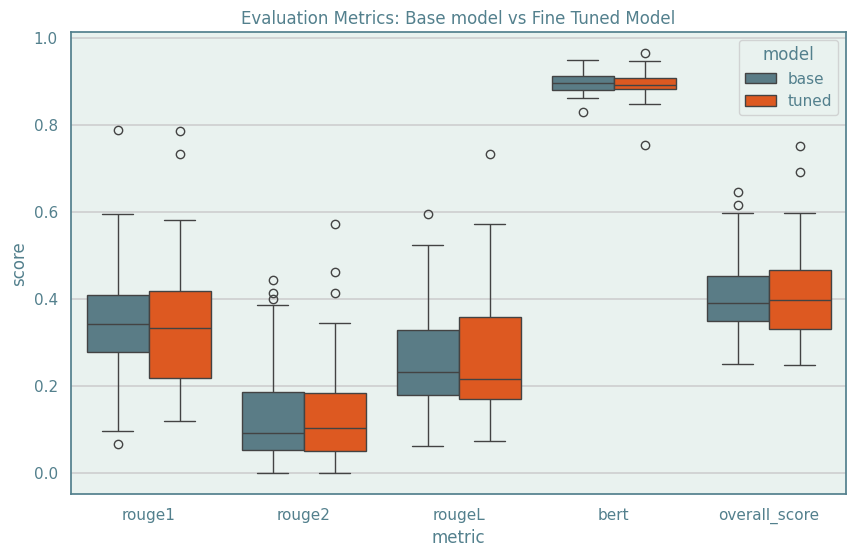

In [181]:
# generate summaries for sample test data
num_samples = data_xsum['test'].num_rows-1
num_to_test = 50
test_indexes = random.sample(range(num_samples),num_to_test)

# get responses from each model
summaries_base_model = generate_responses(data_xsum, original_model, test_indexes,False)
summaries_tuned_model = generate_responses(data_xsum, tuned_model, test_indexes,False)

# Evaluate the performace vs the human labels
# base model:
scores_base = get_model_evaluations(summaries_base_model)

# tuned model
scores_tuned = get_model_evaluations(summaries_tuned_model)

# compare models
scores = compare_evaluations(scores_base, scores_tuned,'overall_score',True)

# Plot Results
plot_evaluation_metrics(scores_base, scores_tuned)